# Back to the Drawing (Bill)board
CMSC 320: Intro to Data Science Final Project

Samuel Lam and Hannah Locraft

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
import statsmodels.graphics.regressionplots as smg
from sklearn.preprocessing import PolynomialFeatures
import sklearn
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.svm import LinearSVR, LinearSVC
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [2]:
pip install recordlinkage

Note: you may need to restart the kernel to use updated packages.


recordlinkage is used for fuzzy matching our two datasets.

In [3]:
import recordlinkage

## Overview

We had a shared interest in music, which led us to try to pursue a music-based problem. Seeing a wealth of data drawn from sources such as the Spotify API, we thought there could be interesting relationships to be found between different songs.

The Billboard Hot 100 is the authoritative record chart for songs in the United States. It is accepted as a very good indicator of how popular a song is in the US. Could there be something in common musically between the various songs that make it to the top?

The Spotify API keeps track of various features of songs stored on the platform. Many of these features are automatically generated by algorithms based on the audio waveforms of the songs themselves. We could use these audio features to examine musical similarities in popular music. Spotify also keeps track of a popularity statistic on its own platform. This could correlate with popularity as defiined by the Billboard chart.

## Data Collection

In [4]:
top_path = "./BillboardFromLast20/billboardHot100_1999-2019.csv"
top_data = pd.read_csv(top_path)
top_data = top_data.drop(['Unnamed: 0', 'Writing.Credits', 'Lyrics', 'Features'], axis=1)
top_data.head()

,Artists,Name,Weekly.rank,Peak.position,Weeks.on.chart,Week,Date,Genre
0,"Lil Nas,",Old Town Road,1,1.0,7.0,2019-07-06,"April 5, 2019","Country,Atlanta,Alternative Country,Hip-Hop,Tr..."
1,"Shawn Mendes, Camila Cabello",Senorita,2,NaN,NaN,2019-07-06,"June 21, 2019",Pop
2,Billie Eilish,Bad Guy,3,2.0,13.0,2019-07-06,"March 29, 2019","Hip-Hop,Dark Pop,House,Trap,Memes,Alternative ..."
3,Khalid,Talk,4,3.0,20.0,2019-07-06,"February 7, 2019","Synth-Pop,Pop"
4,"Ed Sheeran, Justin Bieber",I Don't Care,5,2.0,7.0,2019-07-06,"May 10, 2019","Canada,UK,Dance,Dance-Pop,Pop"


This is the first dataset. It consists of tracks that made it onto the Billboard Hot 100 list between 1999 and 2019. It contains information about artists, genre, and rank on the Billboard. Each week that the track is on the Billboard is a separate entry in the dataset. We dropped certain columns that we did not intend to use. We obtained this dataset from https://www.kaggle.com/danield2255/data-on-songs-from-billboard-19992019. Credit goes to Daniel DeFoe.

In [5]:
attr_path = "./spotify-dataset-19212020-160k-tracks/data.csv"
attr_data = pd.read_csv(attr_path)
attr_data.head()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
0,0.0594,1921,0.982,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878000,10,0.665,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,1921,0.0366,80.954
1,0.9630,1921,0.732,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,7,0.160,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936
2,0.0394,1921,0.961,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913000,3,0.101,-14.850,1,Gati Bali,5,1921,0.0339,110.339
3,0.1650,1921,0.967,['Frank Parker'],0.275,210000,0.309,0,3ftBPsC5vPBKxYSee08FDH,0.000028,5,0.381,-9.316,1,Danny Boy,3,1921,0.0354,100.109
4,0.2530,1921,0.957,['Phil Regan'],0.418,166693,0.193,0,4d6HGyGT8e121BsdKmw9v6,0.000002,3,0.229,-10.096,1,When Irish Eyes Are Smiling,2,1921,0.0380,101.665


This is the second dataset. It consists of data pulled from the Spotify API for tracks on Spotify released between 1921 and 2020. More information on the features of the API can be found at

https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/ for audio features, and

https://developer.spotify.com/documentation/web-api/reference/tracks/get-track/ for track features, such as explicitness or popularity.

We obtained this dataset from https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks. Credit goes to Yamaç Eren Ay.

## Data Processing

In [6]:
top_data['Date'] = pd.to_datetime(top_data['Date'])
top_data['Year'] = top_data['Date'].apply(lambda date: date.year)
attr_data['release_date'] = pd.to_datetime(attr_data['release_date'])

In [7]:
top_data = top_data[top_data['Year'] >= 2010]
attr_data = attr_data[(attr_data['year'] >= 2010)]

We limited our data to the most recent decade (instead of the whole two decades available with the Billboard data), since we needed to fuzzy match them and the number of possible combinations was exponentially large, which our machine could not handle.

In [8]:
f = {'Weekly.rank': 'min', 'Peak.position': 'min', 'Weeks.on.chart': 'max', 'Genre': 'first'}
top_data = top_data.groupby(['Artists', 'Name', 'Year'], as_index = False).agg(f)

Since each week that a track is listed on Billboard is a separate entry in the Billboard dataset, we grouped by artists, name of song, and year, in order to remove these duplicates. We kept the highest position that a track reached, as well as the maximum number of weeks the track had been on the chart.

In [9]:
f = {'valence': 'mean',
     'acousticness': 'mean',
     'danceability': 'mean',
     'duration_ms': 'mean',
     'energy': 'mean',
     'explicit': 'max',
     'instrumentalness': 'mean',
     'key': 'first',
     'liveness': 'mean',
     'loudness': 'mean',
     'mode': 'first',
     'popularity': 'mean',
     'speechiness': 'mean',
     'tempo': 'mean',
    }
attr_data = attr_data.groupby(['artists', 'name', 'year'], as_index = False).agg(f)

We wanted to remove any duplicate entries from the Spotify dataset as well, so we did the same tidying.

In [10]:
def first_artist_top(artists):
    return artists.split(',')[0]

def first_artist_attr(artists):
    return artists.split('\'')[1]

In [11]:
top_data['join_artists'] = top_data['Artists'].apply(first_artist_top)
attr_data['join_artists'] = attr_data['artists'].apply(first_artist_attr)

The artists features in both datasets were comma-separated strings, so we turned them into lists for better processing.

### Dataset matching

In [12]:
top_data[top_data['Name'] == 'Old Town Road']

,Artists,Name,Year,Weekly.rank,Peak.position,Weeks.on.chart,Genre,join_artists
2139,"Lil Nas,",Old Town Road,2019.0,1,1.0,9.0,"Country,Atlanta,Alternative Country,Hip-Hop,Tr...",Lil Nas


In [13]:
attr_data[attr_data['name'] == 'Old Town Road']

,artists,name,year,valence,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,join_artists
11012,['Lil Nas X'],Old Town Road,2019,0.507,0.0578,0.907,113000.0,0.53,0,0.000002,1,0.101,-6.112,1,79.0,0.127,135.998,Lil Nas X


There are inconsistencies between the ways certain artists or song names are listed in the datasets. For example, the artist for the song "Old Town Road" is credited as "Lil Nas" on the Billboard dataset, while he is credited as "Lil Nas X" on the Spotify dataset. Another example of an inconsistency is the name "Senorita". In the Spotify dataset, this name used an ñ, while the Billboard dataset did not.

Therefore, we could not simply join the two datasets by artist and name using built-in Pandas functions, but instead had to use another toolkit that would fuzzy join them.

In [14]:
indexer = recordlinkage.Index()
indexer.block(left_on='Year', right_on='year')
candidates = indexer.index(top_data, attr_data)
print(len(candidates))

7045640


This indicates the number of matches that the fuzzy matching algorithm went through.

In [15]:
compare = recordlinkage.Compare()
compare.string('Name', 'name', threshold=0.85, label='Name')
compare.string('join_artists', 'join_artists', method='jarowinkler', threshold=0.85, label='join_artists')
features = compare.compute(candidates, top_data, attr_data)

In [16]:
features.sum(axis=1).value_counts().sort_index(ascending=False)

2.0       1694
1.0      25473
0.0    7018473
dtype: int64

We can see that the algorithm matched up 1694 entries with both name and artist similar.

In [17]:
potential_matches = features[features.sum(axis=1) > 1].reset_index()
potential_matches['Score'] = potential_matches.loc[:, 'Name':'join_artists'].sum(axis=1)

In [18]:
potential_matches.head()

,level_0,level_1,Name,join_artists,Score
0,42,290,1.0,1.0,2.0
1,43,295,1.0,1.0,2.0
2,45,299,1.0,1.0,2.0
3,48,301,1.0,1.0,2.0
4,50,305,1.0,1.0,2.0


In [19]:
top_data.loc[42, :]

Artists                             5 Seconds Of Summer
Name                                            Amnesia
Year                                               2014
Weekly.rank                                          16
Peak.position                                        16
Weeks.on.chart                                       20
Genre             Australia,Punk Rock,Pop-Rock,Pop,Rock
join_artists                        5 Seconds Of Summer
Name: 42, dtype: object

In [20]:
attr_data.loc[290, :]

artists             ['5 Seconds of Summer']
name                                Amnesia
year                                   2014
valence                               0.108
acousticness                         0.0283
danceability                          0.572
duration_ms                          237248
energy                                0.499
explicit                                  0
instrumentalness                          0
key                                       2
liveness                              0.213
loudness                             -5.237
mode                                      1
popularity                               69
speechiness                          0.0311
tempo                               101.593
join_artists            5 Seconds of Summer
Name: 290, dtype: object

Here we confirmed that the fuzzy matching was successful. The two datasets both contain the same song at the matched indices.

In [21]:
potential_matches.to_csv('matched_data.csv', index=False)  

Since the fuzzy matching took a long time, we saved it to a csv file locally to avoid having to run it again.

In [22]:
data_path = "./matched_data.csv"
data = pd.read_csv(data_path)

Now, we wanted to search for any duplicate matches. To make this easy, we combined the artist and the song name into one string and joined it to the matched indices list.

In [23]:
top_data['Song'] = top_data[['Artists', 'Name']].apply(lambda x: ' - '.join(x), axis=1)
attr_data['Song'] = attr_data[['artists', 'name']].apply(lambda x: ' - '.join(x), axis=1)

In [24]:
top_data_lookup = top_data[['Song']]
attr_data_lookup = attr_data[['Song']]

In [25]:
merged_data = data.join(top_data_lookup, on='level_0', rsuffix = '_top')

In [26]:
merged_data = merged_data.join(attr_data_lookup, on='level_1', lsuffix = '_top', rsuffix = '_attr')

In [27]:
merged_data.head()

,level_0,level_1,Name,join_artists,Score,Song_top,Song_attr
0,42,290,1.0,1.0,2.0,5 Seconds Of Summer - Amnesia,['5 Seconds of Summer'] - Amnesia
1,43,295,1.0,1.0,2.0,5 Seconds Of Summer - Don't Stop,['5 Seconds of Summer'] - Don't Stop
2,45,299,1.0,1.0,2.0,5 Seconds Of Summer - Everything I Didn't Say,['5 Seconds of Summer'] - Everything I Didn't Say
3,48,301,1.0,1.0,2.0,5 Seconds Of Summer - Good Girls,['5 Seconds of Summer'] - Good Girls
4,50,305,1.0,1.0,2.0,5 Seconds Of Summer - Kiss Me Kiss Me,['5 Seconds of Summer'] - Kiss Me Kiss Me


In [28]:
merged_data.to_csv('merged_data.csv', index=False)

Here, we saved the merged indices list and sifted through the values manually to find if there were any duplicate matches. The duplicates are listed below.

In [29]:
merged_data[merged_data['Song_top'] == 'Ace Hood - Bugatti']

,level_0,level_1,Name,join_artists,Score,Song_top,Song_attr
766,103,624,1.0,1.0,2.0,Ace Hood - Bugatti,"['Ace Hood', 'Future', 'Rick Ross'] - Bugatti"
767,103,626,1.0,1.0,2.0,Ace Hood - Bugatti,"['Ace Hood', 'Wiz Khalifa', 'T.I.', 'Meek Mill..."


In [30]:
merged_data[merged_data['Song_top'] == 'MAX - Lights Down Low']

,level_0,level_1,Name,join_artists,Score,Song_top,Song_attr
1036,2330,11914,1.0,1.0,2.0,MAX - Lights Down Low,"['MAX', 'gnash'] - Lights Down Low"
1037,2330,11915,1.0,1.0,2.0,MAX - Lights Down Low,['MAX'] - Lights Down Low


In [31]:
merged_data[merged_data['Song_top'] == 'Fall Out Boy - Irresistible']

,level_0,level_1,Name,join_artists,Score,Song_top,Song_attr
1252,1089,5975,1.0,1.0,2.0,Fall Out Boy - Irresistible,"['Fall Out Boy', 'Demi Lovato'] - Irresistible"
1253,1089,5986,1.0,1.0,2.0,Fall Out Boy - Irresistible,['Fall Out Boy'] - Irresistible


The version of "Bugatti" that made it onto Billboard was the version featuring Future and Rock Ross.
The version of "Lights Down Low" that made it onto Billboard was the version with gnash.
The version of "Irresistible" that made it onto Billboard was the version without Demi Lovato.

In [32]:
data = data.drop([767, 1037, 1252])

Now, we want to join all of the Spotify data features with all of the Billboard data features. We shift back to using the "data" dataframe, to avoid duplicate "Song" features when joining.

In [33]:
data.head()

,level_0,level_1,Name,join_artists,Score
0,42,290,1.0,1.0,2.0
1,43,295,1.0,1.0,2.0
2,45,299,1.0,1.0,2.0
3,48,301,1.0,1.0,2.0
4,50,305,1.0,1.0,2.0


In [34]:
data = data.join(top_data, on='level_0', lsuffix = '_match', rsuffix = '_top')

In [35]:
data = data.join(attr_data, on='level_1', lsuffix = '_top', rsuffix = '_attr')

In [36]:
data.head()

,level_0,level_1,Name_match,join_artists_match,Score,Artists,Name_top,Year,Weekly.rank,Peak.position,...,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,join_artists,Song_attr
0,42,290,1.0,1.0,2.0,5 Seconds Of Summer,Amnesia,2014.0,16,16.0,...,0.000000,2,0.2130,-5.237,1,69.0,0.0311,101.593,5 Seconds of Summer,['5 Seconds of Summer'] - Amnesia
1,43,295,1.0,1.0,2.0,5 Seconds Of Summer,Don't Stop,2014.0,47,47.0,...,0.000015,8,0.0425,-3.468,1,57.0,0.0633,149.946,5 Seconds of Summer,['5 Seconds of Summer'] - Don't Stop
2,45,299,1.0,1.0,2.0,5 Seconds Of Summer,Everything I Didn't Say,2014.0,24,NaN,...,0.000000,9,0.2810,-4.656,1,49.0,0.0955,174.940,5 Seconds of Summer,['5 Seconds of Summer'] - Everything I Didn't Say
3,48,301,1.0,1.0,2.0,5 Seconds Of Summer,Good Girls,2014.0,34,34.0,...,0.000000,4,0.1190,-5.215,1,58.0,0.0828,141.060,5 Seconds of Summer,['5 Seconds of Summer'] - Good Girls
4,50,305,1.0,1.0,2.0,5 Seconds Of Summer,Kiss Me Kiss Me,2014.0,28,NaN,...,0.000000,0,0.1010,-4.775,1,51.0,0.0966,150.049,5 Seconds of Summer,['5 Seconds of Summer'] - Kiss Me Kiss Me


In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1691 entries, 0 to 1693
Data columns (total 33 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   level_0             1691 non-null   int64  
 1   level_1             1691 non-null   int64  
 2   Name_match          1691 non-null   float64
 3   join_artists_match  1691 non-null   float64
 4   Score               1691 non-null   float64
 5   Artists             1691 non-null   object 
 6   Name_top            1691 non-null   object 
 7   Year                1691 non-null   float64
 8   Weekly.rank         1691 non-null   int64  
 9   Peak.position       1386 non-null   float64
 10  Weeks.on.chart      1386 non-null   float64
 11  Genre               1691 non-null   object 
 12  join_artists_top    1691 non-null   object 
 13  Song_top            1691 non-null   object 
 14  artists             1691 non-null   object 
 15  name                1691 non-null   object 
 16  year  

There are a lot of unnecessary columns, so we dropped the ones that were unnecessary (such as the indices from the original datasets) or duplicates (for example, there were two "artists" columns).

In [38]:
data = data.drop(['level_0',
                  'level_1',
                  'Name_match',
                  'Artists',
                  'Name_top',
                  'Year',
                  'Peak.position',
                  'join_artists_match',
                  'Score',
                  'join_artists_top',
                  'Song_top',
                  'Song_attr',
                  'join_artists'
                 ], axis=1)

In [39]:
old_col_names = ['Weekly.rank', 'Weeks.on.chart', 'Genre', 'artists', 'name', 'year',
       'valence', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'explicit', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'popularity', 'speechiness', 'tempo']

new_col_names = ['peak_pos', 'weeks_on_chart', 'genre', 'artists', 'name', 'year',
       'valence', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'explicit', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'popularity', 'speechiness', 'tempo']

res = {old_col_names[i]: new_col_names[i] for i in range(len(old_col_names))}
data.rename(res, axis=1, inplace=True)

We renamed all of the columns for readability. We also dropped entries with NA values, since there were some in the Billboard dataset.

In [40]:
data.dropna(inplace=True)

## Exploratory Data Analysis

We attempted to find correlations between different features in the Spotify dataset with peak position on Billboard, or the number of weeks spent on the charts.

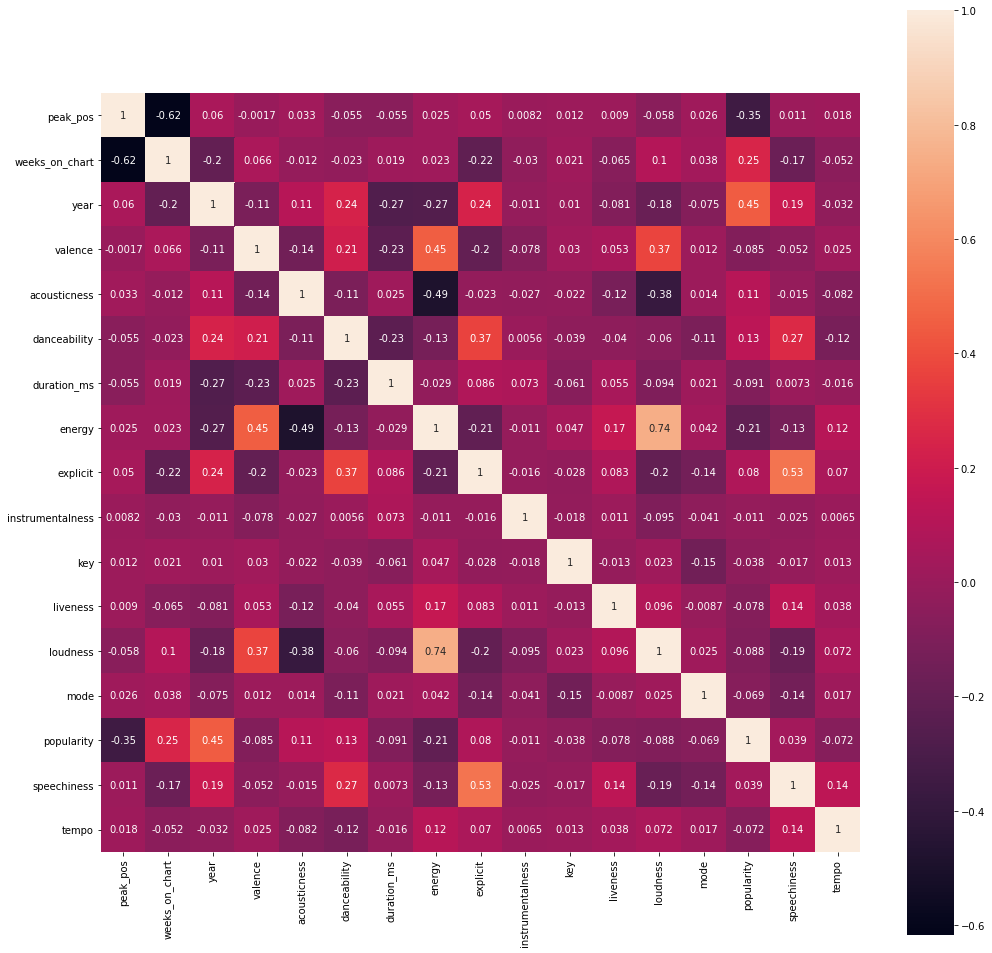

In [41]:
corr = data.corr()
fig, ax = plt.subplots()
fig.set_size_inches(17, 17)
sns.heatmap(corr, annot=True, fmt=".2g", ax=ax, square=True)

The most promising correlation comes from the "popularity" metric, calculated by Spotify based on recent user plays of a particular song. We wanted to see if the plotted data had any noticeable trends.

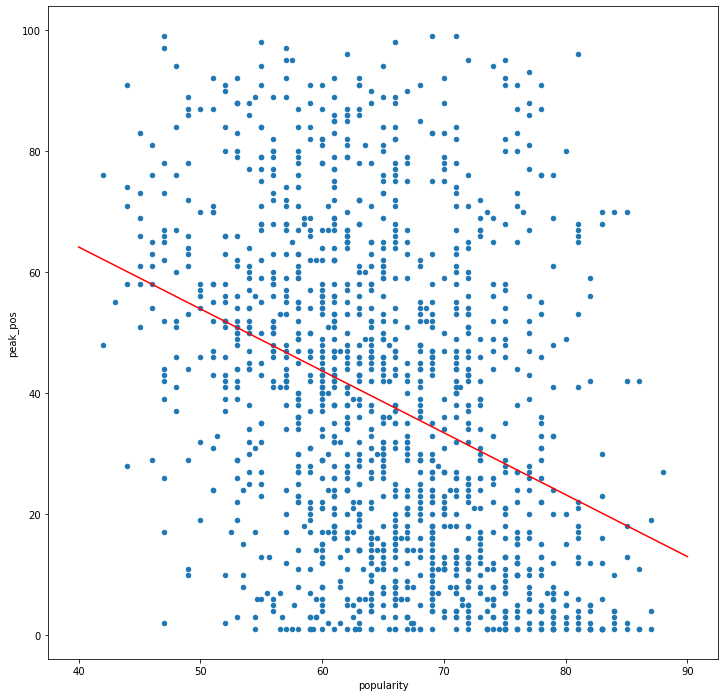

In [44]:
fig = plt.figure()
ax = fig.add_subplot(111)

coeffs = np.polyfit(x = data.popularity, y = data.peak_pos, deg=1)

x = data.popularity
y = data.peak_pos
p = np.poly1d(coeffs)

X = np.linspace(40, 90, num=100, retstep=True)[0]

plt.plot(X, p(X), 'r')
data.plot(x='popularity', y='peak_pos', kind='scatter', figsize=(12,12), ax=ax)

Even though there seems to be some sort of correlation, the error of any regression would be too large to make meaningful predictions or observations about any specific data point.

In [45]:
reg = smf.ols(formula="peak_pos ~ popularity", data=data).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               peak_pos   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.121
Method:                 Least Squares   F-statistic:                     191.2
Date:                Sat, 19 Dec 2020   Prob (F-statistic):           7.79e-41
Time:                        02:21:36   Log-Likelihood:                -6408.9
No. Observations:                1386   AIC:                         1.282e+04
Df Residuals:                    1384   BIC:                         1.283e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    105.0790      4.861     21.618      0.000      95.544     114.614
popularity    -1.0232      0.074    -13.829      0.000      -1.168      -0.878
==============================================================================
Omnibus:                       68.150   Durbin-Watson:                   1.693
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               61.387
Skew:                           0.453   Prob(JB):                     4.68e-14
Kurtosis:                       2.509   Cond. No.                         482.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We can see that the R-squared metric of regression fit to popularity is not very significant, statistically, since the R-squared value is close to 0. The correlation between the two is very weak. Regardless, we also try using some of the scikit-learn models, which show expectedly poor results.

In [49]:
X_train, X_test, y_train, y_test = train_test_split(data['popularity'], data.peak_pos, test_size=0.2)
X_train = X_train.to_numpy().reshape(-1,1)
X_test = X_test.to_numpy().reshape(-1,1)

In [50]:
svr_reg = make_pipeline(StandardScaler(), LinearSVR(random_state=0, tol=1e-5))
svr_reg.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvr', LinearSVR(random_state=0, tol=1e-05))])

In [51]:
score = cross_validate(svr_reg, X_test, y_test, cv=10)
score['test_score'].mean()

0.010319662417028119

### Looking at Genres

Instead of using a numeric Spotify feature, we can also look at genres or artists. We wanted to see if we could use Spotify features to predict genres, in a classification problem.

Since the genres were given as a comma-separated list in the Billboard data, we wanted to transform them into a list and explode them into separate rows. We started again with the dataframe "data", which we had saved a while ago.

In [52]:
genre_data = data.copy()
genre_data['genre'] = data['genre'].apply(lambda x: x.split(','))

genre_cols = ['peak_pos', 'weeks_on_chart', 'artists', 'name', 'year',
       'valence', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'explicit', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'popularity', 'speechiness', 'tempo']
genre_data = genre_data.set_index(genre_cols)['genre'].apply(pd.Series).stack()
genre_data = genre_data.reset_index()
genre_cols += ['genre_num', 'genre_val']
genre_data.columns = genre_cols
genre_data['count'] = 1
genre_data.head(3)

,peak_pos,weeks_on_chart,artists,name,year,valence,acousticness,danceability,duration_ms,energy,...,key,liveness,loudness,mode,popularity,speechiness,tempo,genre_num,genre_val,count
0,16,20.0,['5 Seconds of Summer'],Amnesia,2014,0.108,0.0283,0.572,237248.0,0.499,...,2,0.213,-5.237,1,69.0,0.0311,101.593,0,Australia,1
1,16,20.0,['5 Seconds of Summer'],Amnesia,2014,0.108,0.0283,0.572,237248.0,0.499,...,2,0.213,-5.237,1,69.0,0.0311,101.593,1,Punk Rock,1
2,16,20.0,['5 Seconds of Summer'],Amnesia,2014,0.108,0.0283,0.572,237248.0,0.499,...,2,0.213,-5.237,1,69.0,0.0311,101.593,2,Pop-Rock,1


In [53]:
f = {'peak_pos': 'mean',
     'weeks_on_chart': 'mean',
     'valence': 'mean',
     'acousticness': 'mean',
     'danceability': 'mean',
     'duration_ms': 'mean',
     'energy': 'mean',
     'explicit': 'mean',
     'instrumentalness': 'mean',
     'key': 'first',
     'liveness': 'mean',
     'loudness': 'mean',
     'mode': 'mean',
     'popularity': 'mean',
     'speechiness': 'mean',
     'tempo': 'mean',
     'count': 'count'
    }
agg_genre_data = genre_data.groupby('genre_val', as_index = False).agg(f)

In [54]:
agg_genre_data = agg_genre_data.sort_values(by='count', ascending=False, ignore_index=True).reset_index().head(30)
agg_genre_data.head(10)

,index,genre_val,peak_pos,weeks_on_chart,valence,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,count
0,0,Pop,31.291531,19.328990,0.495862,0.168731,0.635963,223146.101927,0.684365,0.193811,0.004749,2,0.179992,-5.736857,0.633550,68.103827,0.081757,119.996641,614
1,1,Rap,38.975207,13.694215,0.441957,0.143667,0.717105,225146.973829,0.645205,0.818182,0.003800,6,0.202517,-6.307738,0.578512,65.092975,0.191679,126.149296,484
2,2,Country,44.371166,17.515337,0.551108,0.181739,0.571138,214851.165644,0.725011,0.003067,0.002117,2,0.165708,-5.517025,0.907975,59.811350,0.044702,126.220592,326
3,3,R&;B,37.754032,16.762097,0.439778,0.197341,0.645777,228467.299395,0.617191,0.407258,0.006974,6,0.168979,-6.439887,0.556452,66.687164,0.104850,119.241176,248
4,4,Rock,40.326360,19.288703,0.519296,0.148225,0.571077,224662.853556,0.745824,0.037657,0.015648,2,0.172941,-5.573897,0.803347,62.583682,0.050289,124.229084,239
5,5,Trap,40.207101,12.958580,0.379459,0.118048,0.766016,212987.366864,0.580552,0.928994,0.005023,11,0.178714,-6.842512,0.550296,68.249507,0.215765,128.753261,169
6,6,Canada,34.364780,13.276730,0.405076,0.171909,0.678700,233026.037736,0.588156,0.672956,0.004158,10,0.183788,-7.287034,0.540881,66.441300,0.179979,122.334998,159
7,7,Electro-Pop,25.774775,20.432432,0.473707,0.112998,0.655174,217026.845345,0.720443,0.144144,0.005454,7,0.188025,-5.698392,0.513514,69.234234,0.087271,117.885860,111
8,8,Pop-Rock,27.666667,23.401961,0.520718,0.118818,0.598328,215922.122549,0.747966,0.058824,0.005915,2,0.172821,-5.285500,0.696078,68.419935,0.060382,122.200837,102
9,9,Electronic,32.075269,19.516129,0.429656,0.118371,0.651452,225403.623656,0.733280,0.118280,0.024086,4,0.193604,-5.416812,0.505376,69.118280,0.080542,122.231349,93


We wanted to find the most common or prevalent genres on the Billboard Hot 100 and their mean audio feature statistics.

In [55]:
plot_genre_data = genre_data[(genre_data['genre_val'] == 'Pop')
                      | (genre_data['genre_val'] == 'Rap')
                      | (genre_data['genre_val'] == 'R&;B')
                      | (genre_data['genre_val'] == 'Country')
                      | (genre_data['genre_val'] == 'Electronic')
                      | (genre_data['genre_val'] == 'Dance')
                      | (genre_data['genre_val'] == 'Rock')
                      | (genre_data['genre_val'] == 'Alternative')
                     ]

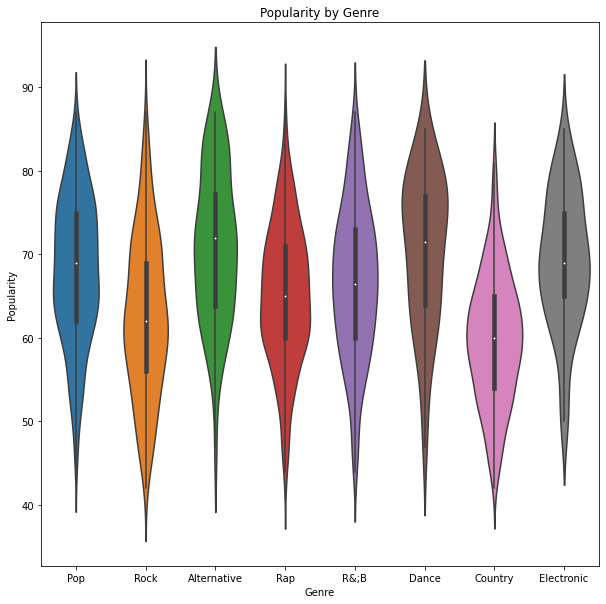

In [83]:
fig, ax = plt.subplots(figsize=(10,10))
sns.violinplot(x="genre_val", y="popularity", data=plot_genre_data, ax=ax)
ax.set(title="Popularity by Genre", xlabel="Genre", ylabel="Popularity")
plt.show()

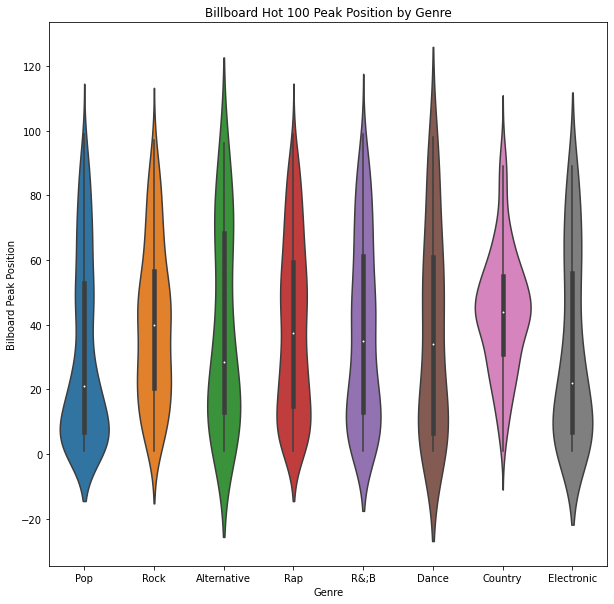

In [84]:
fig, ax = plt.subplots(figsize=(10,10))
sns.violinplot(x="genre_val", y="peak_pos", data=plot_genre_data, ax=ax)
ax.set(title="Billboard Hot 100 Peak Position by Genre", xlabel="Genre", ylabel="Bilboard Peak Position")
plt.show()

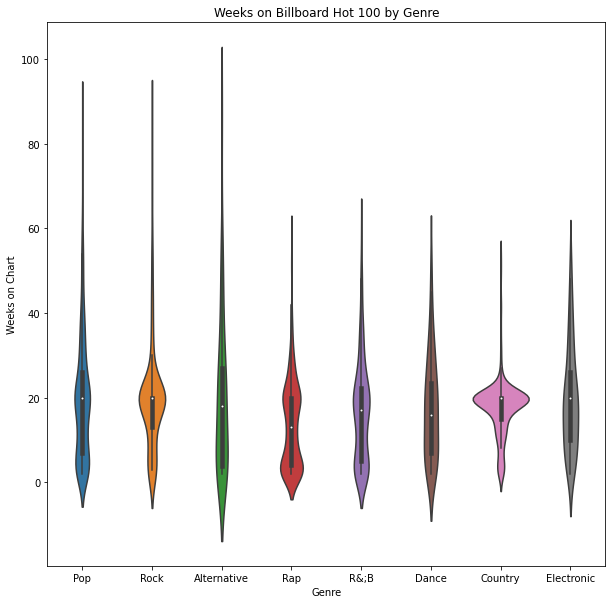

In [85]:
fig, ax = plt.subplots(figsize=(10,10))
sns.violinplot(x="genre_val", y="weeks_on_chart", data=plot_genre_data, ax=ax)
ax.set(title="Weeks on Billboard Hot 100 by Genre", xlabel="Genre", ylabel="Weeks on Chart")
plt.show()

These violin plots show distributions of popularity, Billboard position, or number of weeks on the charts for each genre. The distributions are very similar, even though there are a few slightly notable exceptions, such as country. In general, the medians for the distributions are very close to each other. Regardless of genre, songs that made it onto the Billboard were generally between 60 and 70 popularity according to Spotify, and spent close to 20 weeks on the chart. For peak position, pop and electronic music generally reach a higher peak position on the chart, close to 20, rock and country music generally reach a lower peak position on the chart, close to 40, and the other most prevalent genres reach around #30.

## ML and Analysis

We wanted to solve a multiclass classification problem. We needed to assign an index to each genre, which we could do by merging the aggregated genre list with the base dataset.

In [57]:
genre_data = genre_data.merge(agg_genre_data[['genre_val', 'index']], on='genre_val')

In [86]:
genre_data.head()

,peak_pos,weeks_on_chart,artists,name,year,valence,acousticness,danceability,duration_ms,energy,...,liveness,loudness,mode,popularity,speechiness,tempo,genre_num,genre_val,count,index
0,16,20.0,['5 Seconds of Summer'],Amnesia,2014,0.108,0.028300,0.572,237248.0,0.499,...,0.2130,-5.237,1,69.0,0.0311,101.593,2,Pop-Rock,1,8
1,47,3.0,['5 Seconds of Summer'],Don't Stop,2014,0.892,0.002090,0.571,169936.0,0.957,...,0.0425,-3.468,1,57.0,0.0633,149.946,2,Pop-Rock,1,8
2,34,2.0,['5 Seconds of Summer'],Good Girls,2014,0.557,0.013100,0.531,206424.0,0.915,...,0.1190,-5.215,1,58.0,0.0828,141.060,2,Pop-Rock,1,8
3,24,20.0,['5 Seconds of Summer'],She Looks So Perfect,2014,0.441,0.000569,0.494,202496.0,0.951,...,0.3270,-4.237,1,71.0,0.1320,160.025,2,Pop-Rock,1,8
4,96,3.0,['Andrew McMahon in the Wilderness'],Cecilia And The Satellite,2014,0.239,0.013100,0.381,223880.0,0.844,...,0.3180,-7.123,1,62.0,0.1440,194.000,6,Pop-Rock,1,8


In [58]:
genre_data = genre_data[genre_data['index'] <= 9]

At first, we tried this problem as a single-label problem with 19 classes; however, this turned out to be too many, so we tried a fewer number of classes, just 10.

In [59]:
features = genre_data[['valence',
                       'acousticness',
                       'danceability',
                       'duration_ms',
                       'energy',
                       'explicit',
                       'instrumentalness',
                       'key',
                       'liveness',
                       'loudness',
                       'mode',
                       'popularity',
                       'speechiness',
                       'tempo'
                      ]]
X_train, X_test, y_train, y_test = train_test_split(features, genre_data['index'], test_size=0.2)

We selected all of the features that were numerical, and split the data into training and test sets.

In [60]:
svc_clf = make_pipeline(StandardScaler(), LinearSVC(random_state=0, tol=1e-5, max_iter = 10000))
svc_clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc',
                 LinearSVC(max_iter=10000, random_state=0, tol=1e-05))])

In [61]:
score = cross_validate(svc_clf, X_test, y_test, cv=10, scoring='accuracy')

In [62]:
score['test_score'].mean()

0.36137254901960786

This was the accuracy of a linear support vector classification model.

In [63]:
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)
score = cross_validate(rf_clf, X_test, y_test, cv=10, scoring='accuracy')

In [64]:
score['test_score'].mean()

0.322

This was the accuracy of a random forest classification model.

In [65]:
knn_clf = KNeighborsClassifier(n_neighbors=90)
knn_clf.fit(X_train, y_train)
score = cross_validate(knn_clf, X_test, y_test, cv=10, scoring='accuracy')

In [68]:
score['test_score'].mean()

0.2592549019607843

This was the accuracy of a k-nearest neighbors classification model.

In [69]:
v_clf = VotingClassifier(estimators=[('svc', svc_clf),('rf', rf_clf),('knn', knn_clf)])
v_clf = v_clf.fit(X_train, y_train)
score = cross_validate(v_clf, X_test, y_test, cv=10, scoring='accuracy')

In [70]:
score['test_score'].mean()

0.35549019607843135

Finally, we put the three classifiers into a voting classifier to see if we could get a higher accuracy, which ended up not being better than the linear SVC model: 0.355 vs 0.361, respectively.

In [71]:
categories = ['Pop',
             'Rap',
             'Country',
             'R&;B',
             'Rock',
             'Trap',
             'Canada',
             'Electro-Pop',
             'Pop-Rock',
             'Electronic'
             ]

def transform_genres(genre_str):
    genres = genre_str.split(',')
    result = np.zeros(len(categories))
    for genre in genres:
        if genre in categories:
            result[categories.index(genre)] = 1
    return result

training_data = data.copy()
training_data['genre'] = data['genre'].apply(transform_genres)

Next, we tried making the problem a multilabel, multiclass problem. We transformed the genre lists into arrays of 0s or 1s corresponding to each of the genres we used.

In [72]:
features = training_data[['valence',
                       'acousticness',
                       'danceability',
                       'duration_ms',
                       'energy',
                       'explicit',
                       'instrumentalness',
                       'key',
                       'liveness',
                       'loudness',
                       'mode',
                       'popularity',
                       'speechiness',
                       'tempo'
                      ]]
X_train, X_test, y_train, y_test = train_test_split(features, training_data.genre, test_size=0.2)

In [73]:
classifier = OneVsRestClassifier(LinearSVC(max_iter=50000))
classifier.fit(X_train, y_train.tolist())
predicted = classifier.predict(X_test)

/opt/conda/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/conda/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/conda/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/conda/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/conda/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("L

In [74]:
for i in range(5):
    print(predicted[i])

[0 0 1 0 0 0 1 0 0 1]
[0 0 1 0 0 0 1 0 0 1]
[0 0 1 0 0 0 1 0 0 1]
[0 0 1 0 0 0 1 0 0 1]
[0 0 1 0 0 0 1 0 0 1]


Unfortunately, even with 50000 iterations, the SVC was not able to converge properly and ended up predicted the same genres for every data point passed in. We decided to stop pursuing this problem here, due to the poor performance of the model. We were not very familiar with multilabel problems when starting this project, so we were unable to improve it.

### Looking at Artists

If none of the Spotify audio/track features correlated with the Billboard genres, maybe we could look at correlations between artist and Billboard rank or number of weeks on the chart. We had to start over with the original Billboard dataset.

In [105]:
top_path = "./BillboardFromLast20/billboardHot100_1999-2019.csv"
top_data = pd.read_csv(top_path)
top_data = top_data.drop(['Unnamed: 0', 'Writing.Credits', 'Lyrics', 'Features'], axis=1)
top_data.head()

,Artists,Name,Weekly.rank,Peak.position,Weeks.on.chart,Week,Date,Genre
0,"Lil Nas,",Old Town Road,1,1.0,7.0,2019-07-06,"April 5, 2019","Country,Atlanta,Alternative Country,Hip-Hop,Tr..."
1,"Shawn Mendes, Camila Cabello",Senorita,2,NaN,NaN,2019-07-06,"June 21, 2019",Pop
2,Billie Eilish,Bad Guy,3,2.0,13.0,2019-07-06,"March 29, 2019","Hip-Hop,Dark Pop,House,Trap,Memes,Alternative ..."
3,Khalid,Talk,4,3.0,20.0,2019-07-06,"February 7, 2019","Synth-Pop,Pop"
4,"Ed Sheeran, Justin Bieber",I Don't Care,5,2.0,7.0,2019-07-06,"May 10, 2019","Canada,UK,Dance,Dance-Pop,Pop"


In [106]:
top_data['Date'] = pd.to_datetime(top_data['Date'])
top_data['Year'] = top_data['Date'].apply(lambda date: date.year)

This is a repeat of code performed near the top of the tutorial. Once again, we had to remove duplicate entries from songs that had been on the Billboard for multiple weeks.

In [107]:
f = {'Weekly.rank': 'min', 'Peak.position': 'min', 'Weeks.on.chart': 'max', 'Genre': 'first'}
top_data = top_data.groupby(['Artists', 'Name', 'Year'], as_index = False).agg(f)

In [108]:
top_data['Artists'] = top_data['Artists'].apply(lambda x: x.split(','))
top_data.drop('Weekly.rank', axis=1)

,Artists,Name,Year,Peak.position,Weeks.on.chart,Genre
0,"[""Weird Al"" Yankovic]",Canadian Idiot,2006.0,82.0,3.0,"Comedy,Parody,Rock"
1,"[""Weird Al"" Yankovic]",Word Crimes,2014.0,39.0,2.0,"Parody,Comedy,Pop"
2,['N Sync],Bye Bye Bye,2000.0,4.0,23.0,"Adult Contemporary,Dance-Pop,Teen Pop,Boy Band..."
3,['N Sync],Gone,2001.0,11.0,24.0,"Adult Contemporary,Acoustic,Soul Pop,R&;B,Boy ..."
4,['N Sync],It's Gonna Be Me,2000.0,1.0,25.0,"Memes,Dance-Pop,Teen Pop,Boy Band,Pop"
...,...,...,...,...,...,...
6189,[will.i.am],Fall Down,2013.0,NaN,NaN,Rap
6190,[will.i.am],I Got It From My Mama,2007.0,31.0,9.0,Rap
6191,[will.i.am],It's A New Day,2008.0,78.0,2.0,Rap
6192,"[will.i.am, Britney Spears]",Scream & Shout,2012.0,3.0,24.0,Rap


In [109]:
top_cols = ['Name', 'Year', 'Peak.position', 'Weeks.on.chart', 'Genre']
top_data = top_data.set_index(top_cols)['Artists'].apply(pd.Series).stack()
top_data = top_data.reset_index()
top_cols = ['name', 'year', 'peak_pos', 'weeks_on_chart', 'genre', 'artist_num', 'artist']
top_data.columns = top_cols
top_data['count'] = 1
top_data.head()

,name,year,peak_pos,weeks_on_chart,genre,artist_num,artist,count
0,Canadian Idiot,2006.0,82.0,3.0,"Comedy,Parody,Rock",0,"""Weird Al"" Yankovic",1
1,Word Crimes,2014.0,39.0,2.0,"Parody,Comedy,Pop",0,"""Weird Al"" Yankovic",1
2,Bye Bye Bye,2000.0,4.0,23.0,"Adult Contemporary,Dance-Pop,Teen Pop,Boy Band...",0,'N Sync,1
3,Gone,2001.0,11.0,24.0,"Adult Contemporary,Acoustic,Soul Pop,R&;B,Boy ...",0,'N Sync,1
4,It's Gonna Be Me,2000.0,1.0,25.0,"Memes,Dance-Pop,Teen Pop,Boy Band,Pop",0,'N Sync,1


This time, instead of summing up the number of songs per genre, we aggregated by artist. Then we sorted the list to see which artists most frequently appeared on the Billboard Hot 100.

In [111]:
agg_top_data = top_data.groupby('artist', as_index = False).agg('count')
agg_top_data = agg_top_data.sort_values(by='count', ascending=False, ignore_index=True).reset_index().head(30)
agg_top_data.head(10)

,index,artist,name,year,peak_pos,weeks_on_chart,genre,artist_num,count
0,0,Glee Cast,178,178,30,30,178,178,178
1,1,Drake,125,125,105,105,125,125,125
2,2,Taylor Swift,72,72,51,51,72,72,72
3,3,Lil Wayne,61,61,32,32,61,61,61
4,4,Eminem,54,54,39,39,54,54,54
5,5,Justin Bieber,48,48,31,31,48,48,48
6,6,Future,47,47,24,24,47,47,47
7,7,Kanye West,46,46,40,40,46,46,46
8,8,Beyonce,45,45,43,43,45,45,45
9,9,Chris Brown,44,44,40,40,44,44,44


In [113]:
plot_top_data = top_data[(top_data['artist'] == 'Glee Cast')
                         | (top_data['artist'] == 'Drake')
                         | (top_data['artist'] == 'Taylor Swift')
                         | (top_data['artist'] == 'Lil Wayne')
                         | (top_data['artist'] == 'Eminem')
                         | (top_data['artist'] == 'Justin Bieber')
                         | (top_data['artist'] == 'Future')
                         | (top_data['artist'] == 'Kanye West')
                        ]

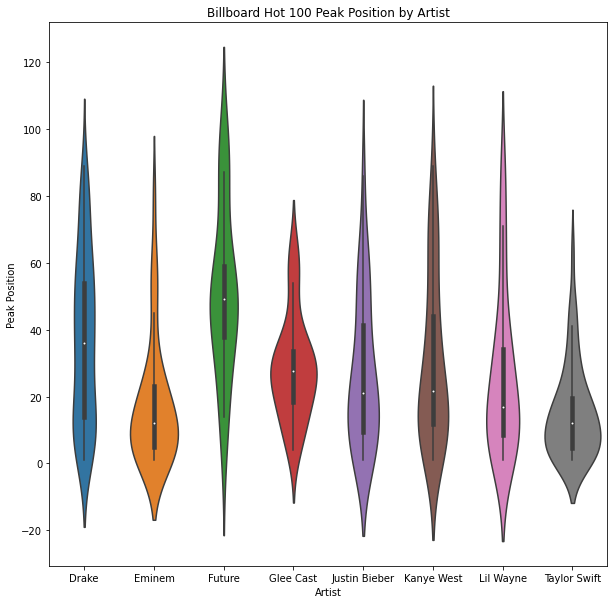

In [115]:
fig, ax = plt.subplots(figsize=(10,10))
sns.violinplot(x="artist", y="peak_pos", data=plot_top_data, ax=ax)
ax.set(title="Billboard Hot 100 Peak Position by Artist", xlabel="Artist", ylabel="Peak Position")
plt.show()

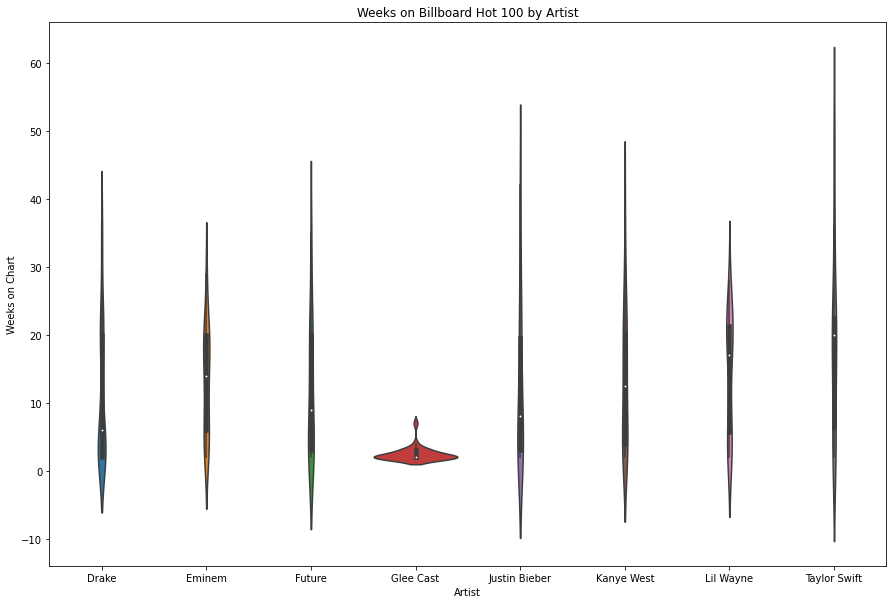

In [118]:
fig, ax = plt.subplots(figsize=(15,10))
sns.violinplot(x="artist", y="weeks_on_chart", data=plot_top_data, ax=ax)
ax.set(title="Weeks on Billboard Hot 100 by Artist", xlabel="Artist", ylabel="Weeks on Chart")
plt.show()

These violin plots show distributions of Billboard position or number of weeks on the charts for each of the top 10 artists. For peak position, the rapper Future and the group Glee Cast tended to peak lower compared to the other top artists, and remained on the charts much lower. On the other hand, Eminem and Taylor Swift tended to peak much higher, and had more songs that remained on the charts longer. Overall, there is a wide range of the number of weeks any artist's songs remained on the charts, with the notable exception of Glee Cast.

Ultimately, we also felt that we would not be able to find any meaningful relationships between Billboard statistics and artists.

## Insights and Future Direction

Unfortunately, we were not able to produce an appealing model to explain relationships between various features in our datasets. Prior to the work in this tutorial, we had also put in much effort in trying to predict Spotify popularity using Spotify audio features. However, after making several models and tuning them, we discovered that the popularity metric is influenced mostly by the year of a song's release, rather than any specific audio feature. In fact, the audio features had almost no effect on a song's popularity.

In total, for this project, we attempted to investigate the relationships between Spotify features, such as energy and popularity, between Billboard statistics and Spotify features, such as peak position and popularity, between genres and Spotify features, and between Billboard statistics and artists.

For the machine learning aspects of this project, because our models were not very good, we could not progress further with tuning them, such as hyperparameter grid search, which we had attempted in previous work on Spotify popularity that was also not fruitful.

Overall, the popularity of music seems to be too complex to be explained solely by the audio features we have in the datasets. Even after much wrangling and model tuning, in the case of our previous work, we were unable to find convincing or meaningful correlations. There may be other external factors that we were unable to investigate in the boundaries of this project. Finding these would be good potential for a future data science project.